The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==0.17.1


# *Weight Decay*
:label:`sec_weight_decay`


Agora que caracterizamos o problema de *overfitting*,
podemos apresentar algumas técnicas padrão para regularizar modelos.
Lembre-se de que sempre podemos mitigar o *overfitting*
saindo e coletando mais dados de treinamento.
Isso pode ser caro, demorado,
ou totalmente fora de nosso controle,
tornando-o impossível a curto prazo.
Por enquanto, podemos assumir que já temos
tantos dados de alta qualidade quanto nossos recursos permitem
e focar em técnicas de regularização.

Lembre-se disso em nosso
exemplo de regressão polinomial
(:numref:`sec_model_selection`)
poderíamos limitar a capacidade do nosso modelo
simplesmente ajustando o grau
do polinômio ajustado.
Na verdade, limitar o número de características
é uma técnica popular para mitigar o *overfitting*.
No entanto, simplesmente deixando de lado as características
pode ser um instrumento muito rude para o trabalho.
Ficando com o exemplo da regressão polinomial, considere o que pode acontecer
com entradas de alta dimensão.
As extensões naturais de polinômios
a dados multivariados são chamados de *monômios*,
que são simplesmente produtos de potências de variáveis.
O grau de um monômio é a soma das potências.
Por exemplo, $x_1^2 x_2$, e $x_3 x_5^2$ são ambos monômios de grau 3.

Observe que o número de termos com grau $d$
explode rapidamente à medida que $d$ fica maior.
Dadas as variáveis $k$, o número de monômios
de grau $d$ (ou seja, $k$ escolheu $d$) é ${k - 1 + d} \choose {k - 1}$.
Mesmo pequenas mudanças no grau, digamos de $2$ a $3$,
aumentam drasticamente a complexidade do nosso modelo.
Portanto, muitas vezes precisamos de uma ferramenta mais refinada
para ajustar a complexidade da função.


## Normas e *Weight Decay*


Nós descrevemos
a norma $L_2$ e a norma $L_1$,
que são casos especiais da norma $L_p$ mais geral
em :numref: `subsec_lin-algebra-norms`.
(***Weight Decay* (comumente chamada de regularização $L_2$),
pode ser a técnica mais amplamente usada
para regularizar modelos paramétricos de aprendizado de máquina.**)
A técnica é motivada pela intuição básica
que entre todas as funções $f$,
a função $f = 0$
(atribuindo o valor $0$ a todas as entradas)
é em certo sentido a *mais simples*,
e que podemos medir a complexidade
de uma função por sua distância de zero.
Mas com que precisão devemos medir
a distância entre uma função e zero?
Não existe uma única resposta certa.
Na verdade, ramos inteiros da matemática,
incluindo partes da análise funcional
e a teoria dos espaços de Banach,
se dedicam a responder a esta questão.

Uma interpretação simples pode ser
para medir a complexidade de uma função linear
$f(\mathbf{x}) = \mathbf{w}^\top \mathbf{x}$
por alguma norma de seu vetor de peso, por exemplo, $\| \mathbf{w} \|^2$.
O método mais comum para garantir um vetor de peso pequeno
é adicionar sua norma como um termo de penalidade
para o problema de minimizar a perda.
Assim, substituímos nosso objetivo original,
*minimizando a perda de previsão nos rótulos de treinamento*,
com novo objetivo,
*minimizando a soma da perda de previsão e o prazo de penalização*.
Agora, se nosso vetor de peso ficar muito grande,
nosso algoritmo de aprendizagem pode se concentrar
sobre como minimizar a norma de peso $\| \mathbf{w} \|^2$
vs. minimizar o erro de treinamento.
Isso é exatamente o que queremos.
Para ilustrar coisas no código,
vamos reviver nosso exemplo anterior
de :numref:`sec_linear_regression` para regressão linear.
Lá, nossa perda foi dada por

$$L(\mathbf{w}, b) = \frac{1}{n}\sum_{i=1}^n \frac{1}{2}\left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right)^2.$$

Lembre-se de que $\mathbf{x}^{(i)}$ são as características,
$y^{(i)}$ são rótulos para todos os exemplos de dados $i$ e $(\mathbf{w}, b)$
são os parâmetros de peso e polarização, respectivamente.
Para penalizar o tamanho do vetor de peso,
devemos de alguma forma adicionar $\| \mathbf{w} \|^2$ para a função de perda,
mas como o modelo deve negociar a
perda padrão para esta nova penalidade aditiva?
Na prática, caracterizamos essa compensação
por meio da *constante de regularização* $\lambda$,
um hiperparâmetro não negativo
que ajustamos usando dados de validação:

$$L(\mathbf{w}, b) + \frac{\lambda}{2} \|\mathbf{w}\|^2,$$


Para $\lambda = 0$, recuperamos nossa função de perda original.
Para $\lambda > 0$, restringimos o tamanho de $\| \mathbf{w} \|$.
Dividimos por $2$ por convenção:
quando tomamos a derivada de uma função quadrática,
o $2$ e $1/2$ cancelam, garantindo que a expressão
para a atualização pareça agradável e simples.
O leitor astuto pode se perguntar por que trabalhamos com o quadrado
norma e não a norma padrão (ou seja, a distância euclidiana).
Fazemos isso por conveniência computacional.
Ao elevar a norma $L_2$ ao quadrado, removemos a raiz quadrada,
deixando a soma dos quadrados de
cada componente do vetor de peso.
Isso torna a derivada da penalidade fácil de calcular: a soma das derivadas é igual à derivada da soma.


Além disso, você pode perguntar por que trabalhamos com a norma $L_2$
em primeiro lugar e não, digamos, a norma $L_1$.
Na verdade, outras escolhas são válidas e
popular em todas as estatísticas.
Enquanto modelos lineares $L_2$-regularizados constituem
o algoritmo clássico de *regressão ridge*,
regressão linear $L_1$-regularizada
é um modelo igualmente fundamental em estatística, popularmente conhecido como *regressão lasso*.



Uma razão para trabalhar com a norma $L_2$
é que ela coloca uma penalidade descomunal
em grandes componentes do vetor de peso.
Isso influencia nosso algoritmo de aprendizagem
para modelos que distribuem o peso uniformemente
em um número maior de *features*.
Na prática, isso pode torná-los mais robustos
ao erro de medição em uma única variável.
Por outro lado, penalidades de $L_1$ levam a modelos
que concentram pesos em um pequeno conjunto de recursos, zerando os outros pesos.
Isso é chamado de *seleção de recursos*,
o que pode ser desejável por outras razões.


Usando a mesma notação em :eqref:`eq_linreg_batch_update`,
as atualizações de gradiente descendente estocástico de *minibatch*
para regressão $L_2$-regularizada seguem:

$$
\begin{aligned}
\mathbf{w} & \leftarrow \left(1- \eta\lambda \right) \mathbf{w} - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \mathbf{x}^{(i)} \left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right).
\end{aligned}
$$


Como antes, atualizamos $\mathbf{w}$ com base no valor
pelo qual nossa estimativa difere da observação.
No entanto, também reduzimos o tamanho de $\mathbf{w}$ para zero.
É por isso que o método às vezes é chamado de "queda de pesos" (*weigth decay*):
dado o termo de pena sozinho,
nosso algoritmo de otimização *decai*
o peso em cada etapa do treinamento.
Em contraste com a seleção de recursos,
o *weight decay* nos oferece um mecanismo contínuo
para ajustar a complexidade de uma função.
Valores menores de $\lambda$ correspondem
para $\mathbf{w}$, menos restritos
enquanto valores maiores de $\lambda$
restringem $\mathbf{w}$ mais consideravelmente.

Se incluirmos uma penalidade de polarização correspondente $b^2$
pode variar entre as implementações,
e pode variar entre as camadas de uma rede neural.
Muitas vezes, não regularizamos o termo de polarização
da camada de saída de uma rede.

## Regressão Linear de Alta Dimensão

Podemos ilustrar os benefícios do
*weight decay*
por meio de um exemplo sintético simples.


In [1]:
%matplotlib inline
import tensorflow as tf
from d2l import tensorflow as d2l

Primeiro, nós [**geramos alguns dados como antes**]

(**$$y = 0.05 + \sum_{i = 1}^d 0.01 x_i + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.01^2).$$**)

Escolhemos nosso rótulo para ser uma função linear de nossas entradas,
corrompidas por ruído gaussiano com média zero e desvio padrão 0,01.
Para tornar os efeitos do *overfitting* pronunciados,
podemos aumentar a dimensionalidade do nosso problema para $d = 200$
e trabalhar com um pequeno conjunto de treinamento contendo apenas 20 exemplos.


In [2]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = tf.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

## Implementação do Zero

A seguir, implementaremos o *weight decay* do zero,
simplesmente adicionando a penalidade quadrada de $L_2$
para a função de destino original.

### [**Inicializando os Parâmetros do Modelo**]

Primeiro, vamos definir uma função
para inicializar aleatoriamente os parâmetros do nosso modelo.


In [3]:
def init_params():
    w = tf.Variable(tf.random.normal(mean=1, shape=(num_inputs, 1)))
    b = tf.Variable(tf.zeros(shape=(1, )))
    return [w, b]

### (**Definindo Penalidade de Norma $L_2$**)

Talvez a maneira mais conveniente de implementar essa penalidade
é colocar todos os termos no lugar e resumi-los.


In [4]:
def l2_penalty(w):
    return tf.reduce_sum(tf.pow(w, 2)) / 2

### [**Definindo o *Loop* de Treinamento**]

O código a seguir se ajusta a um modelo no conjunto de treinamento
e avalia no conjunto de teste.
A rede linear e a perda quadrada
não mudaram desde :numref:`chap_linear`,
então iremos apenas importá-los via `d2l.linreg` e` d2l.squared_loss`.
A única mudança aqui é que nossa perda agora inclui o prazo de penalidade.


In [5]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with tf.GradientTape() as tape:
                # The L2 norm penalty term has been added, and broadcasting
                # makes `l2_penalty(w)` a vector whose length is `batch_size`
                l = loss(net(X), y) + lambd * l2_penalty(w)
            grads = tape.gradient(l, [w, b])
            d2l.sgd([w, b], grads, lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('L2 norm of w:', tf.norm(w).numpy())

### [**Treinamento sem Regularização**]

Agora executamos este código com `lambd = 0`,
desabilitando o *weight decay*.
Observe que fizemos muito *overfitting*,
diminuindo o erro de treinamento, mas não o
erro de teste --- um caso clássico de *overfitting*.


L2 norm of w: 17.227089


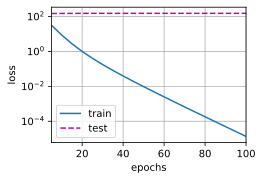

In [6]:
train(lambd=0)

### [**Usando *Weight Decay***]

Abaixo, executamos com *weight decay* substancial.
Observe que o erro de treinamento aumenta
mas o erro de teste diminui.
Este é precisamente o efeito
esperamos da regularização.


L2 norm of w: 0.5071529


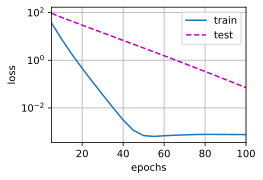

In [7]:
train(lambd=3)

## [**Implementação Concisa**]

Como o *weight decay* é onipresente
na otimização da rede neural,
a estrutura de *deep learning* torna-o especialmente conveniente,
integrando o *weight decay* no próprio algoritmo de otimização
para fácil uso em combinação com qualquer função de perda.
Além disso, essa integração tem um benefício computacional,
permitindo truques de implementação para adicionar *weight decay* ao algoritmo,
sem qualquer sobrecarga computacional adicional.
Uma vez que a parte de *weight decay* da atualização
depende apenas do valor atual de cada parâmetro,
o otimizador deve tocar em cada parâmetro uma vez de qualquer maneira.


No código a seguir, criamos um regularizador $L_2$ com
o hiperparâmetro de redução de peso `wd` e aplicamos-no à camada
através do argumento `kernel_regularizer`.


In [8]:
def train_concise(wd):
    net = tf.keras.models.Sequential()
    net.add(tf.keras.layers.Dense(
        1, kernel_regularizer=tf.keras.regularizers.l2(wd)))
    net.build(input_shape=(1, num_inputs))
    w, b = net.trainable_variables
    loss = tf.keras.losses.MeanSquaredError()
    num_epochs, lr = 100, 0.003
    trainer = tf.keras.optimizers.SGD(learning_rate=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with tf.GradientTape() as tape:
                # `tf.keras` requires retrieving and adding the losses from
                # layers manually for custom training loop.
                l = loss(net(X), y) + net.losses
            grads = tape.gradient(l, net.trainable_variables)
            trainer.apply_gradients(zip(grads, net.trainable_variables))
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('L2 norm of w:', tf.norm(net.get_weights()[0]).numpy())

[**Os gráficos parecem idênticos aos de quando
implementamos *weight decay* do zero**].
No entanto, eles funcionam consideravelmente mais rápido
e são mais fáceis de implementar,
um benefício que se tornará mais
pronunciado para problemas maiores.


L2 norm of w: 1.4396566


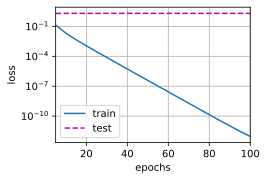

In [9]:
train_concise(0)

L2 norm of w: 0.034869876


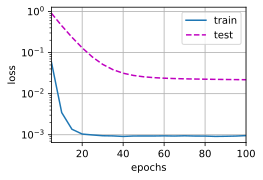

In [10]:
train_concise(3)

Até agora, nós apenas tocamos em uma noção de
o que constitui uma função linear simples.
Além disso, o que constitui uma função não linear simples
pode ser uma questão ainda mais complexa.
Por exemplo, [reproduzindo o espaço de Hilbert do kernel (RKHS)](https://en.wikipedia.org/wiki/Reproducing_kernel_Hilbert_space)
permite aplicar ferramentas introduzidas
para funções lineares em um contexto não linear.
Infelizmente, algoritmos baseados em RKHS
tendem a ser mal dimensionados para dados grandes e dimensionais.
Neste livro, usaremos a heurística simples
de aplicar o *weight decay* em todas as camadas de uma rede profunda.

## Resumo

* A regularização é um método comum para lidar com *overfitting*. Ela adiciona um termo de penalidade à função de perda no conjunto de treinamento para reduzir a complexidade do modelo aprendido.
* Uma escolha particular para manter o modelo simples é o *weight decay* usando uma penalidade de $L_2$. Isso leva à diminuição do peso nas etapas de atualização do algoritmo de aprendizagem.
* A funcionalidade de *weight decay* é fornecida em otimizadores de estruturas de *deep learning*.
* Diferentes conjuntos de parâmetros podem ter diferentes comportamentos de atualização no mesmo loop de treinamento.



## Exercícios

1. Experimente o valor de $\lambda$ no problema de estimação desta seção. Plote o treinamento e a precisão do teste como uma função de $\lambda$. O que você observa?
1. Use um conjunto de validação para encontrar o valor ideal de $\lambda$. É realmente o valor ideal? Isso importa?
1. Como seriam as equações de atualização se em vez de $\|\mathbf{w}\|^2$ usássemos $\sum_i |w_i|$ como nossa penalidade de escolha (regularização $L_1$)?
1. Sabemos que $\|\mathbf{w}\|^2 = \mathbf{w}^\top \mathbf{w}$.  Você pode encontrar uma equação semelhante para matrizes (veja a norma Frobenius em :numref: `subsec_lin-algebra-norms`)?
1. Revise a relação entre o erro de treinamento e o erro de generalização. Além do *weight decay*, aumento do treinamento e o uso de um modelo de complexidade adequada, de que outras maneiras você pode pensar para lidar com o *overfitting*?
1. Na estatística bayesiana, usamos o produto anterior e a probabilidade de chegar a um posterior via $P(w \mid x) \propto P(x \mid w) P(w)$. Como você pode identificar $P(w)$ com regularização?


[Discussions](https://discuss.d2l.ai/t/236)


<!--stackedit_data:
eyJoaXN0b3J5IjpbLTE2MDUxMTY3NSwtNTQ3MTM1NTczLDgxOD
M3Mjk4NSwtMjAyNzEyMTk0NSwxMjIyNTI1NTUyLDIwNzUyNzYx
OTAsMTEwNTI2OTIyMCwtMTYxMjQ2Nzk2MCw3MDMzNDExODYsMT
U4Mjg3ODIzNywtMTA2ODI0Mzk5MV19
-->
